# [0] 적금 군집분석 개요

- 목표
    - 비지도 학습을 통해 학습별 군집을 나누고, 각 군집의 특성 파악
    - 군집 특성별 고객 세분화 및 상품 추천

</br>

- 고려 사항
    - 선택 column
        - 군집분석의 경우 columns 선택에 따라 차이가 많이남
        - 수치형과 범주형 column 함께 봐야함
    - 군집분석 알고리즘
        - K-means
        - K-modes
        - 계층적 군집화
    - df
        - 각 개월 별
            - 개월 선택 후 속에서 군집 분류
        - 통합본
            - 개월을 선택하지 않고 개월 단위로도 비교하여 볼 수 있음

# [1] 모듈

- 글꼴 설치
- 드라이브 연동
- 모듈 로드
- 시드 고정

- 나눔글꼴 설치 및 적용
    - 설치 후 런타임 재시작 필요

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

- 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# os
import os
import sys
import re
import warnings
import random

# 분석
import pandas as pd
import numpy as np


# 시각화
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ML
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

warnings.filterwarnings('ignore')
%matplotlib inline

- 시드 고정

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

# [2] 데이터

## [2-1] 데이터 로드

- bank_info_df : 은행 등급 계산
- is_df : 전체 적금 상품 데이터
- is(개월수)_df : 개월별 적금 상품 데이터

In [ ]:
bank_info_df = pd.read_csv("/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/경영지표/bank_grade.csv",encoding = 'cp949')

is_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_all.csv', encoding = 'utf-8')
is6_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_6.csv', encoding = 'utf-8')
is12_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_12.csv', encoding = 'utf-8')
is24_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_24.csv', encoding = 'utf-8')
is36_df = pd.read_csv('/content/drive/MyDrive/ASAC/final/data/금융감독원데이터/상품데이터_크롤링/적금/installment_saving_36.csv', encoding = 'utf-8')

## [2-2] 데이터 확인

- bank_info_df
    - 98개 은행에 대한 각 등급
    - 등급 :  1 ~ 5 등급으로 분포
    - 등급 분류 : 은행_등급.ipynb 에 자세히 나와있음

In [ ]:
bank_info_df.head(2)

,Unnamed: 0,구분,유형,BIS비율_등급,유동성비율_등급,총자산_등급,안정성,여신비율_등급,대손충당금_등급,자기자본_등급,건전성,ROA_등급,당기순이익_등급,수익성,총합계,등급
0,0,주식회사 카카오뱅크,은행,107,116,83,52.0,129,100,87,28.85,79,81,16.0,96.85,1
1,1,남양저축은행,저축은행,109,90,39,45.6,114,108,49,20.90,145,75,22.0,88.50,1


- is(개월수)_df
    - 각 개월별 상품 크롤링 데이터
    - 크롤링 : crawler_installment_saving.py
    - 개월별 상품수
        - 6월 : 251개
        - 12월 : 388개
        - 24개월 : 334개
        - 36개월 : 301개

In [ ]:
is6_df.shape, is12_df.shape, is24_df.shape, is36_df.shape

((251, 17), (388, 17), (334, 17), (301, 17))

- is_df
    - 총 상품 393개
    - 상품별로 통합된 데이터
        - 각 개월에 대한 데이터는 column으로 포함되어 있음
    - 데이터 통합 : merge_data_.ipynb


In [ ]:
is_df.head(2)

,금융회사,상품명,적립방식,세전이자율_6,세후이자율_6,최고우대금리_6,세전이자율_12,세후이자율_12,최고우대금리_12,세전이자율_24,...,우대조건_6,우대조건_12,우대조건_24,우대조건_36,이자계산방식,담당부서 및 연락처,가입대상,가입방법,기타유의사항,은행_상품_계산
0,MS저축은행,정기적금,정액적립식,3.50%,2.96%,3.50%,4.30%,3.64%,4.30%,4.10%,...,없음,없음,없음,없음,단리,"기획회계팀,053-742-4411",없음,"영업점,인터넷,스마트폰",없음,MS저축은행_정기적금_단리_정액적립식_없음
1,민국저축은행,e-행복정기적금(인터넷),정액적립식,3.00%,2.54%,3.00%,4.10%,3.47%,4.10%,4.10%,...,- 없음,- 없음,- 없음,- 없음,단리,"기획팀, 02-2271-0071",개인,인터넷,- 중도해지 시 가입 기간에 따라 중도해지이율이 다르게 적용됩니다.,민국저축은행_e-행복정기적금(인터넷)_단리_정액적립식_개인


# [3] 데이터 전처리

## [3-1] 범주형 전처리

### 금융회사 종류 추가

In [ ]:
def financial_kind(df) :

    bank_list = list(set(list(df['금융회사'].unique())))

    # 저축은행(jb)와 일반은행(gb)로 분할한다.
    jb = []
    gb = []
    ob = ['주식회사 카카오뱅크',  '토스뱅크 주식회사', '주식회사 케이뱅크']

    for bank in bank_list:
        if '저축' in bank:
            jb.append(bank)
        else:
            gb.append(bank)

    gb_not_ob = [bank for bank in gb if bank not in ob]

    df['금융회사_종류'] =  df['금융회사'].apply(lambda x: '저축은행' if x in jb else ('온라인은행' if x in ob else ('일반은행' if x in gb_not_ob else None)))
    return df

In [ ]:
is_df = financial_kind(is_df)
is6_df = financial_kind(is6_df)
is12_df = financial_kind(is12_df)
is24_df = financial_kind(is24_df)
is36_df = financial_kind(is36_df)

### 은행 등급 추가

- 크롤링 데이터의 은행명과 핵심 경영지표의 은행명과 차이 처리
    - 영어 => 한글
    - 저축은행 => 상호저축은행
- 각 은행별 등급 추가

In [ ]:
grade_dict = {
    'OSB저축은행': '오에스비저축은행',
    'JT친애저축은행': '제이티친애저축은행',
    'OK저축은행': '오케이저축은행',
    'MS저축은행': '엠에스상호저축은행',
    'DH저축은행': '디에이치저축은행',
    'JT저축은행': '제이티저축은행',
    'BNK저축은행': '비엔케이저축은행',
    '푸른저축은행': '푸른상호저축은행',
    'SBI저축은행': '에스비아이저축은행',
    '유니온저축은행': '유니온상호저축은행',
    'IBK저축은행': '아이비케이저축은행',
    '세람저축은행': '세람상호저축은행',
    'KB저축은행': '케이비저축은행',
    '대원저축은행': '대원상호저축은행'
}

In [ ]:
def bank_grade(df):
    df['금융회사'] = df['금융회사'].apply(lambda x: grade_dict[x]if x in grade_dict.keys() else x )
    df = pd.merge(left = df, right = bank_info_df[['구분','등급']], how = 'left',
            left_on = '금융회사' , right_on = "구분")
    df.drop(columns = '구분', inplace = True)
    return df

In [ ]:
is_df = bank_grade(is_df)
is6_df = bank_grade(is6_df)
is12_df = bank_grade(is12_df)
is24_df = bank_grade(is24_df)
is36_df = bank_grade(is36_df)

### 가입대상 컬럼 전처리

- 가입대상부터 전체 데이터는 따로 전처리가 필요


- 가입대상 컬럼, 가입대상.1 컬럼 존재
    - 가입대상 : 제한없음, 일부제한 만 존재
    - 가입대상.1 : 가입대상 더 세분화

- 따라서 가입대상 컬럼이 아닌, 가입대상.1을 사용함

</br>

-  **가입대상_최종** 컬럼으로 사용

In [ ]:
def target(df):
    # 가입대상.1 사용
    df['가입대상_최종'] = df['가입대상.1']

    # '가입대상'과 '가입대상.1' 칼럼 삭제 (통합)
    df.drop(['가입대상', '가입대상.1'], axis=1, inplace=True)

    # 비어있는 값 '가입대상제한없음'으로 채운다.
    df['가입대상_최종'].fillna('가입대상제한없음', inplace=True)
    return df

In [ ]:
is6_df = target(is6_df)
is12_df = target(is12_df)
is24_df = target(is24_df)
is36_df = target(is36_df)

- 가입대상 제한없음 통일
     - 가입대상 조건을 추출하되, 없음/제한없음 등 실질적으로 가입대상 제한조건이 없는 경우는 모두 "제한없음"으로 통일해줌

In [ ]:
word_list = ["없음","제한없음","누구나가입","모든고객", '실명의개인', "개인", "누구나가입가능", '누구나 가입가능']
def target_unity(df):
    target_list = []
    for i in range(len(df)):
        text = str(df.loc[i,'가입대상_최종'])
        text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', "", text)
        text = text.replace(" ","")
        Flag = False
        for w in word_list:
            if w == text:
                Flag = True
                break
        if Flag == True :
            target_list.append('가입대상제한없음')
        else:
            target_list.append(df.loc[i,'가입대상_최종'])

    df['가입대상_최종'] = target_list
    return df


In [ ]:
is6_df = target_unity(is6_df)
is12_df = target_unity(is12_df)
is24_df = target_unity(is24_df)
is36_df = target_unity(is36_df)

- 가입대상 나이 추출

In [ ]:
range_list = ['미만','이하','이상','초과']
p =re.compile('[0-9]+세')
p2 = re.compile('[0-9]+~[0-9]+세')
p3 = re.compile('[0-9]+~[0-9]+대')

def target_age(df):
    age_list = []
    for i in range(len(df)):
        text_ori = df.loc[i,'가입대상_최종']
        text = text_ori.replace(" ","")

        if p3.search(text):
            s = p3.search(text).span()
            age_list.append(text[s[0]:s[1]])
        elif p2.search(text):
            s = p2.search(text).span()
            age_list.append(text[s[0]:s[1]])
        elif p.search(text):
            s = p.search(text).span()
            for r in range_list:
                range_w = ""
                if text[s[1]:s[1]+2] == r:
                    range_w = text[s[1]:s[1]+2]
                    break
            age_list.append(text[s[0]:s[1]] +" " +  range_w)
        else:
            age_list.append("나이제한없음")

    df['나이제한'] = age_list
    return df

In [ ]:
is6_df = target_age(is6_df)
is12_df = target_age(is12_df)
is24_df = target_age(is24_df)
is36_df = target_age(is36_df)

### 가입 방법 전처리

In [ ]:
join_method_mapping = {
    '인터넷,스마트폰': '인터넷스마트폰전용',
    '영업점': '영업점방문',
    '스마트폰': '인터넷스마트폰전용',
    '스마트폰,전화(텔레뱅킹)' : '인터넷스마트폰전용',
    '인터넷': '인터넷스마트폰전용',
    '영업점,인터넷': '인터넷스마트폰영업점',
    '인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰전용',
    '영업점,인터넷,스마트폰': '인터넷스마트폰영업점',
    '영업점,스마트폰': '인터넷스마트폰영업점',
    '영업점,인터넷,스마트폰,전화(텔레뱅킹)': '인터넷스마트폰영업점',
    '없음' : '기타',
    '모집인' : '기타'
}

def method(df) :
    df['가입방법'] = df['가입방법'].map(join_method_mapping)
    return df

In [ ]:
is6_df = method(is6_df)
is12_df = method(is12_df)
is24_df = method(is24_df)
is36_df = method(is36_df)

### 우대조건 전처리


- 우대조건이 없을경우 우대사항 없음으로 통일

In [ ]:
no_prime = ['없음', '해당없음', '','해당사항없음',  '우대조건없음', '우대사항없음' ,  '해당무']

def clean_condition(df):
    def clean_text(inputString):
        text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', '', inputString)
        return text_rmv

    df['우대조건'] = df['우대조건'].apply(lambda x: '우대사항없음' if clean_text(x).replace(" ","")in no_prime else x)
    return df

In [ ]:
is6_df = clean_condition(is6_df)
is12_df = clean_condition(is12_df)
is24_df = clean_condition(is24_df)
is36_df = clean_condition(is36_df)

- 가입방식 우대
- 자동이체 우대
- 만기 이후 우대사항
- 실적 우대
- 기타 우대
    - 마켓딩 동의
    - 청약가입
    - 최초 고객
    - 직장인
    - 해당은행

In [ ]:
def preferential(df):

    # 가입방식 우대
    def create_method(x):
        method_list_e = ['인터넷','모바일','스마트','비대면']
        for m in method_list_e :
            if m in x :
                return '비대면'
        method_list = ['창구','영업점']
        for m in method_list:
            if m in x :
                return "대면"
        return "가입방식우대없음"

    # 이체 우대
    def transfer(x):
        if "이체" not in x:
            return "이체우대없음"
        if "자동" in x:
            return "자동이체우대"
        if "급여" in x  or "소득" in x :
            return "급여이체우대"

    # 만기 우대
    def maturity(x):
        if "만기" not in x:
            return "만기시우대없음"
        if "만기" in x:
            return "만기시우대"

    # 실적 우대
    def card(x):
        if "실적" not in x and "카드" not in x:
            return "실적우대없음"
        if "카드" in x:
            return "카드실적우대"
        if "실적" in x:
            return "카드 외 실적우대"

    # 기타우대
    def etc(x):
        list_ = []
        if "동의" in x:
            list_.append("마켓팅동의우대")
        if "청약" in x:
            list_.append("청약가입우대")
        if ("신규" in x )or ("첫거래" in x) or ("최초" in x )or( "첫번째" in x):
            list_.append("최초고객우대")
        if "직장인" in x or "근로자" in x :
            list_.append("직장인우대")
        if "당행" in x or "당사" in x:
            list_.append("해당은행우대")
        if not list_:
            return "기타우대없음"
        else:
            return " ".join(list_)

    df['가입방식우대_존재여부'] = df['우대조건'].apply(lambda x :create_method(x) )
    df['이체우대_존재여부'] = df['우대조건'].apply(lambda x :transfer(x) )
    df['만기우대_존재여부'] = df['우대조건'].apply(lambda x :maturity(x) )
    df['실적우대_존재여부'] = df['우대조건'].apply(lambda x :card(x) )
    df['기타우대_존재여부'] = df['우대조건'].apply(lambda x :etc(x) )

    return df

In [ ]:
is6_df = preferential(is6_df)
is12_df = preferential(is12_df)
is24_df = preferential(is24_df)
is36_df = preferential(is36_df)

## [3-2] 수치형 전처리

- 문자열을 수치형으로 변환

- 파생변수
    - 최고_기본_diff : 최고 우대금리 - 세전이자율
    - 최고_기준_diff : 최고우대금리 - 현재금리 (3.5)
    - 실질이자율

#### % 문자열 수치형 변환

In [ ]:
def str_to_float(df):
    df['세전이자율'] = df['세전이자율'].apply(lambda x : np.nan if "%" not in x else x)
    df['세전이자율'] = df['세전이자율'].str.rstrip('%').astype('float')
    df['세후이자율'] = df['세후이자율'].apply(lambda x : np.nan if "%" not in x else x)
    df['세후이자율'] = df['세후이자율'].str.rstrip('%').astype('float')
    df['최고우대금리'] = df['최고우대금리'].apply(lambda x : np.nan if "%" not in x else x)
    df['최고우대금리'] = df['최고우대금리'].str.rstrip('%').astype('float')
    df = df.apply(lambda x : x.fillna(x['최고우대금리']) if np.isnan(x['세전이자율']) else x, axis = 1)
    df = df.apply(lambda x : x.fillna(x['세전이자율']) if np.isnan(x['최고우대금리']) else x, axis = 1)
    return df

In [ ]:
is6_df = str_to_float(is6_df)
is12_df = str_to_float(is12_df)
is24_df = str_to_float(is24_df)
is36_df = str_to_float(is36_df)

#### 실질이자율 생성

- 실질 이자율 : 만기 후 받게되는 이자의 현시점 기준 가치 산출
- 참고 : https://github.com/todhm/finda


In [ ]:
bir = 0.035 # 현재 기준금리 3.5% 반영

# 단리계산
def month_real(interest,month):
    if not np.isnan(interest):
        a =  - sum([ -100 / (1 + bir) ** (i/12.0)   for i in range(0,month)]) #만기시까지 지급한 금액의 현재가치
        b = 100.0 * month + np.sum([ 100 * (interest * 0.01) * i / 12.0   for i in range(1,month + 1)]) #만기후 수령액의 미래가치
        b = b / (1.0125)**(month/12.0) # 만기후 수령액의 현재가치

        return ((b/a)**(12.0/month) - 1) * 100
    else:
        return 0

# 복리계산
def month_complex_real(interest,month):
    if interest != np.nan:
        a =  - sum([ -100 / (1+ bir) ** (i/12.0)   for i in range(0,month)])
        b = np.sum([ 100 *   (1+ ((interest * 0.01) / 12.0)) ** (i)  for i in range(1,month + 1)])
        b = b / (1 + bir)**(month/12.0)
        return ((b/a)**(12.0/month) - 1) * 100
    else:
        return 0


In [ ]:
def real_interest(df, month):
    real_interest_list = []
    for i in range(len(df)):
        if df.loc[i, '이자계산방식'] == '단리':  # 상품의 금리방식이 단리인 경우
            real_interest_list.append(month_real(df.loc[i, '세전이자율'], month))


        elif df.loc[i, '이자계산방식'] == '복리':  # 상품의 금리방식이 복리인 경우
            real_interest_list.append(month_complex_real(df.loc[i, '세전이자율'], month))
    df['실질이자율'] = real_interest_list
    return df


In [ ]:
is6_df = real_interest(is6_df, 6)
is12_df = real_interest(is12_df, 12)
is24_df = real_interest(is24_df, 24)
is36_df = real_interest(is36_df, 36)

#### 파생변수 생성

- 최고_기본_diff
    - 최고 우대 - 기본
- 최고_기준_diff
    - 최고 우대 - 현재금리(3.5)

In [ ]:
def create_val(df):
    df['최고_기본_diff'] = df['최고우대금리'] - df['세전이자율']
    bir = 3.5
    df['최고_기준_diff'] = df['최고우대금리'] - bir
    return df

In [ ]:
is6_df = create_val(is6_df)
is12_df = create_val(is12_df)
is24_df = create_val(is24_df)
is36_df = create_val(is36_df)

# [4] 군집분석

- df_tmp 선택

## 그래프 함수

In [ ]:
# column 별 분포 그래프

def plot_cluster_comparison(df, feature , r, n):
    plt.subplot(r,2, n)
    ax = sns.barplot(x='cluster_num', y=feature, data=df, palette='Paired')

    for p in ax.patches:
         ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.title(f'군집별 평균 {feature} 비교')

    plt.xlabel('군집')
    plt.ylabel(feature)


In [ ]:
def  plot_cluster_comparison_cat(df, label_mapping, feature , r, n):

    plt.subplot(r,2, n)
    ax = sns.countplot(x='cluster_num', hue= feature, data=df, palette='hls')

    # label list
    label = list(label_mapping[feature].keys())
    # annotations 추가
    for p in ax.patches:
        # ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
        #             ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
        #             textcoords='offset points')
        ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / len(label), p.get_height()),
            ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')

    plt.legend(title=feature, loc='upper right', labels=list(label_mapping[feature].keys()))

    # 점선 추가
    # for i in range(len(ax.patches) // 2):
    #     plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)
    for i in range(len(ax.patches) // len(label)):
        plt.axvline(x=(1 * i + 0.5), color='gray', linestyle='--', linewidth=0.8)

    plt.title(f'군집별 {feature} 분포')
    plt.xlabel('Cluster Number')
    plt.ylabel('Count')


## [4-1] 6개월 상품 군집분석

In [ ]:
df_tmp = is6_df.copy()

- 전처리

In [ ]:
# 수치형 columns list
num_col_list = ['세전이자율', '세후이자율', '최고우대금리','실질이자율', '최고_기본_diff','최고_기준_diff' ]

# 범주형 columns list
cat_col_list = ['적립방식','이자계산방식','가입방법','금융회사_종류', '등급', '나이제한', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부' ]

### 수치형 군집분석 : K-means

- 분포가 비슷하기 때문에 세전 이자율, 세후 이자율 중 하나만 선택
- 실질 이자율의 차이를 더 크게 보고 싶다면 복리와 단리의 차이를 함께 주는 것이 좋을 것이라고 생각


In [ ]:
df_num_tmp = df_tmp[num_col_list]

In [ ]:
df_num_tmp.info()

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_num_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_num_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 k로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=9, random_state=22)
kmeans.fit(df_num_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_num_tmp['cluster_num'] = kmeans.labels_

In [ ]:
df_num_tmp['상품명'] = df_tmp['상품명']
df_num_tmp['은행명'] = df_tmp['금융회사']

In [ ]:
df_result_km = df_num_tmp.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

In [ ]:
plt.figure(figsize=(20, 13))
for e, c in enumerate(df_num_tmp.columns[:-3]):
    col_n = int((len(df_num_tmp.columns) - 3) / 2 + 1)
    plot_cluster_comparison(df_num_tmp,c,col_n, e+1)

plt.show()

### 범주형 군집분석 : k-means

- 범주형만 모두 넣어서 k-means를 통한 군집 분석을 했을 때에는 좋은 결과가 나오지 않음
- 잘 분류된 col
    - 적립방식
    - 이자계산방식
    - 가입방식
    - 등급

In [ ]:
df_cat_tmp = df_tmp[cat_col_list]

In [ ]:
# 인코딩
label_mapping = {}

label_encoder = LabelEncoder()
for col in cat_col_list:
    df_cat_tmp[col] = label_encoder.fit_transform(df_cat_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_cat_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_cat_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=22)
kmeans.fit(df_cat_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_cat_tmp['cluster_num'] = kmeans.labels_

In [ ]:
plt.figure(figsize=(20, 13))
for e, c in enumerate(df_cat_tmp.columns[:-1]):
    col_n = int((len(df_cat_tmp.columns)) / 2 + 1)
    plot_cluster_comparison(df_cat_tmp,c,col_n, e+1)

plt.show()

### 범주형 군집분석 : 계층적 군집분석 (ward)

- 8개 군집 분석

In [ ]:
# ward을 이용한 경우
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

k_range = range(2,14)
score_list = []
for k in k_range:
  ward_clustering = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
  ward_cluster = ward_clustering.fit_predict(df_cat_tmp)
  score = silhouette_score(df_cat_tmp, ward_cluster)
  score_list.append(score)

plt.plot(range(2, 14), score_list, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

In [ ]:
clusters = AgglomerativeClustering(n_clusters = 8, linkage = 'ward')
clusters.fit(df_cat_tmp)
# clusters.labels_
df_cat_tmp['cluster_num'] =clusters.labels_

In [ ]:
plt.figure(figsize=(20, 13))
for e, c in enumerate(df_cat_tmp.columns[:-1]):
    col_n = int((len(df_cat_tmp.columns)) / 2 + 1)
    plot_cluster_comparison(df_cat_tmp,c,col_n, e+1)

plt.show()

### 통합 군집분석 : K-means

In [ ]:

df_tmp = is6_df.copy()
choice_num = [ '실질이자율','최고_기준_diff','최고우대금리','세전이자율']
choice_cat = ['적립방식','가입방법','이자계산방식','금융회사_종류']
choice_list = choice_num + choice_cat

In [ ]:
df_ch_tmp = df_tmp[choice_list]

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

df_ch_tmp[choice_num] = scaler.fit_transform(df_ch_tmp[choice_num])

In [ ]:
# 인코딩
label_mapping = {}

label_encoder = LabelEncoder()
for col in choice_cat:
    df_ch_tmp[col] = label_encoder.fit_transform(df_ch_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

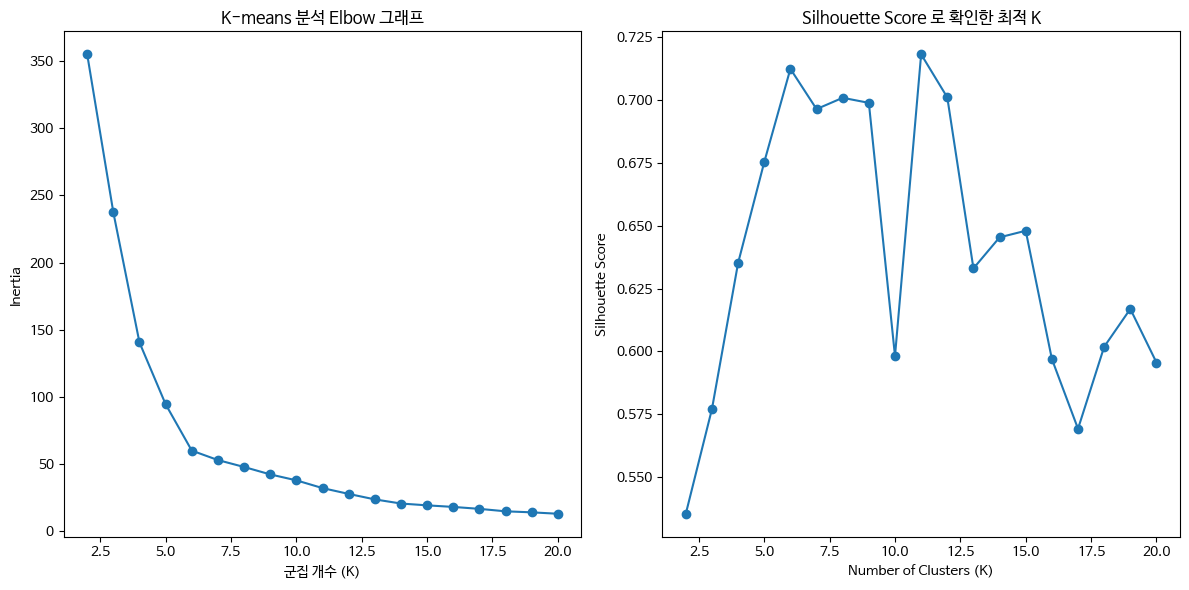

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k,  random_state=22, max_iter = 777)
    kmeans.fit(df_ch_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_ch_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 k로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=22, max_iter = 777)
kmeans.fit(df_ch_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_ch_tmp['cluster_num'] = kmeans.labels_

# 실루엣 지수 확인
silhouette_score(df_ch_tmp, kmeans.labels_)

0.7330217655393669

In [ ]:
df_ch_tmp['상품명'] = df_tmp['상품명']
df_ch_tmp['은행명'] = df_tmp['금융회사']

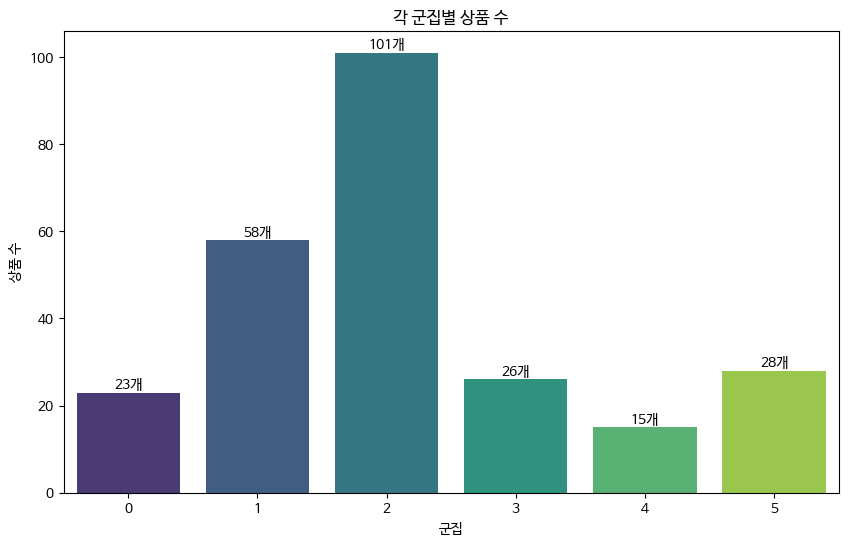

In [ ]:
df_result_km = df_ch_tmp.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

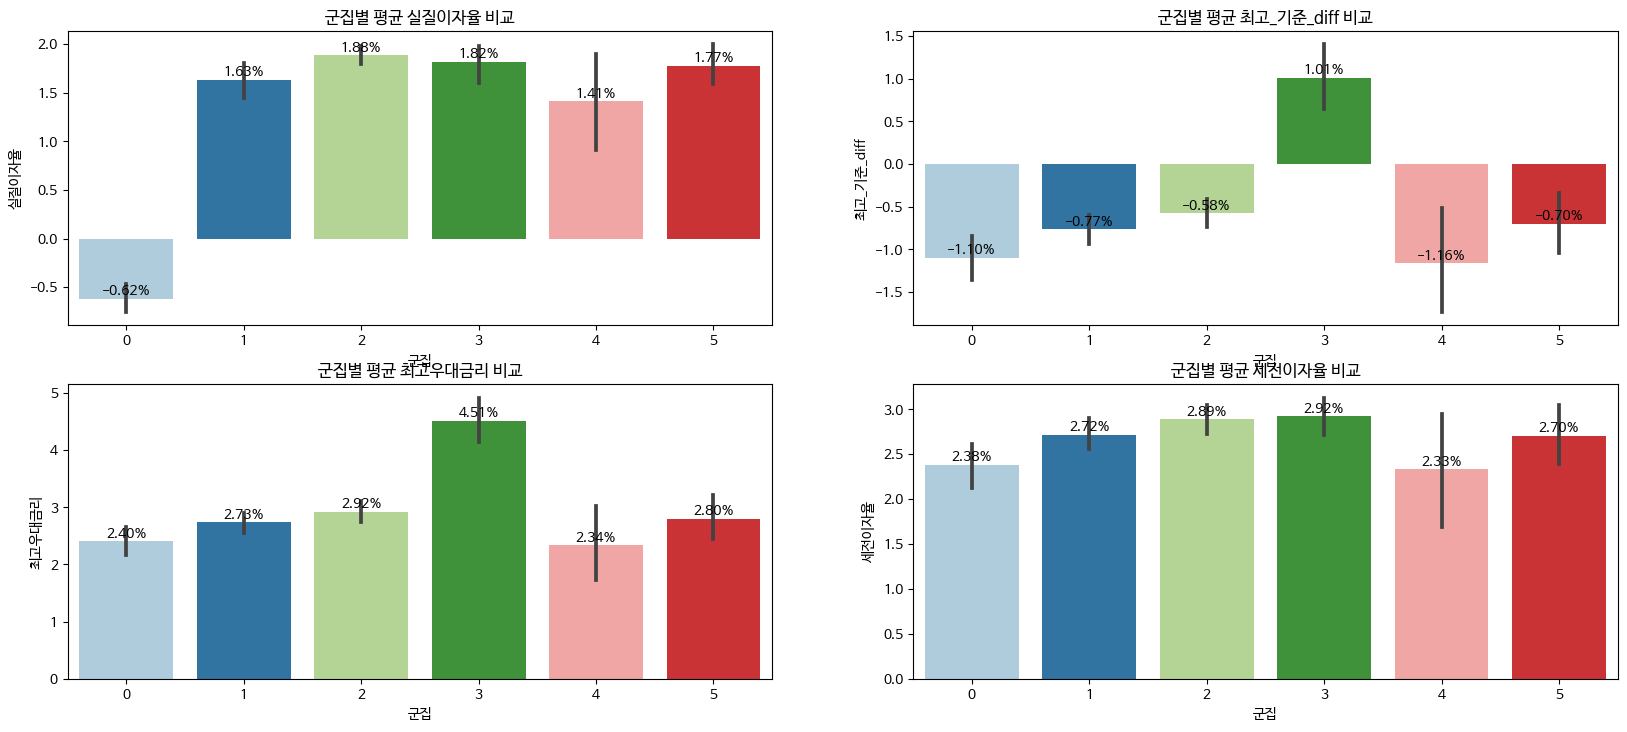

In [ ]:
df_ch_tmp[choice_num] = scaler.inverse_transform(df_ch_tmp[choice_num])
plt.figure(figsize=(20, 13))
for e, c in enumerate(choice_num):
    col_n = int((len(choice_num)) / 2 + 1)
    plot_cluster_comparison(df_ch_tmp,c,col_n, e+1)


plt.show()

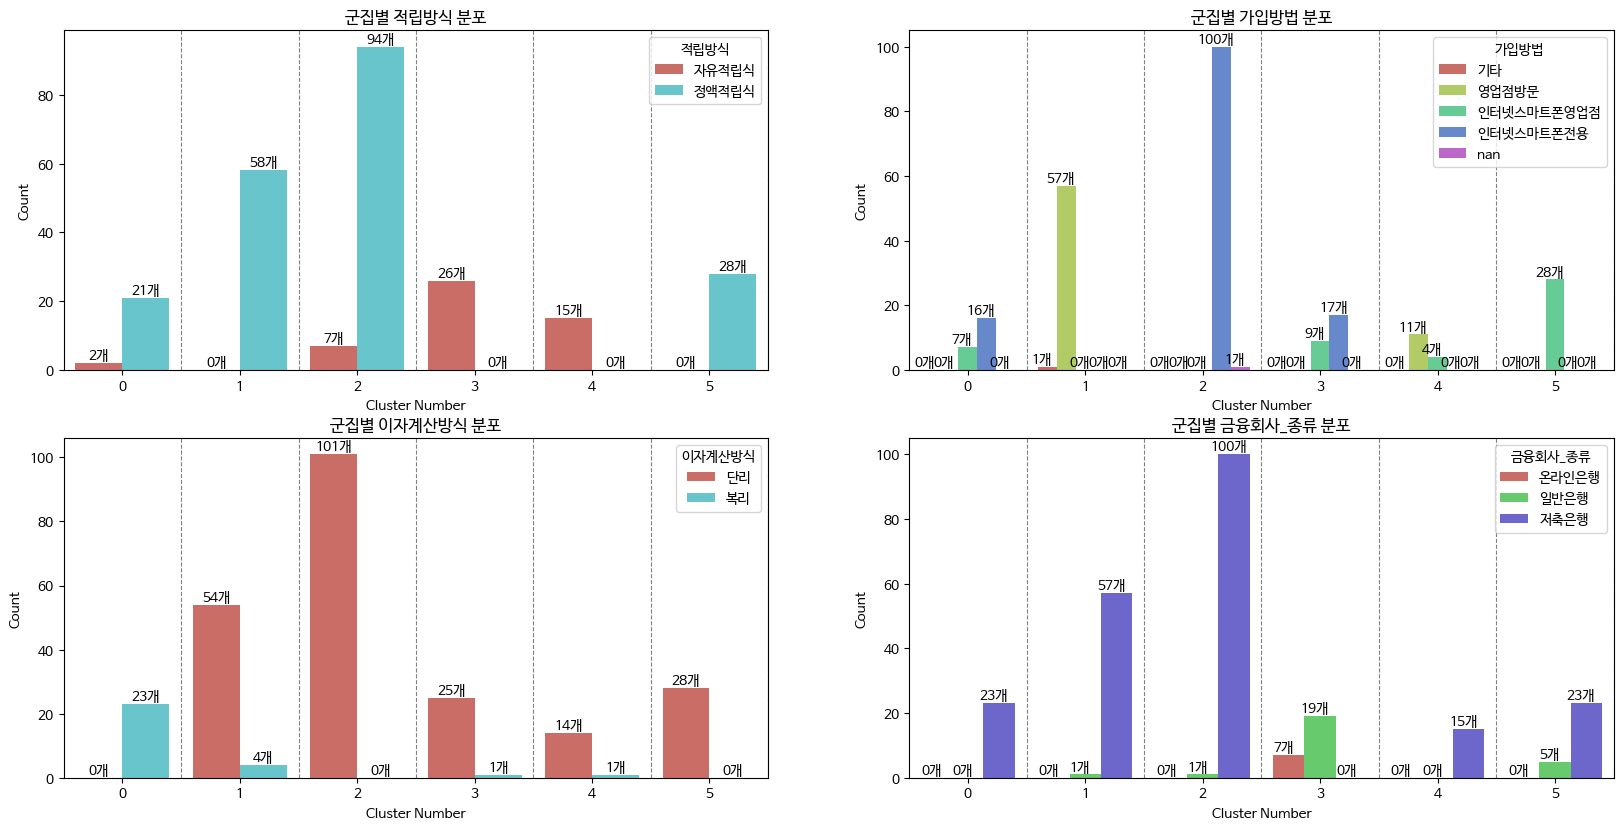

In [ ]:
plt.figure(figsize=(20, 15))
for e, c in enumerate(choice_cat):
    col_n = int((len(choice_cat)) / 2 + 1)
    plot_cluster_comparison_cat(df_ch_tmp,label_mapping, c,col_n, e+1)


plt.show()

In [ ]:
df_ch_tmp.to_csv("./is6_df.csv", encoding = 'cp949')

### 총 군집별 특성

**총 6개 군집**

1. 0번 군집
    - 101개 상품으로 가장 많은 상품을 포함하고 있음
    - 이자 계산 방식은 모두 단리 이며 정액 적립식 상품이 대다수를 차지함
    - 모두 인터넷, 스마트폰 전용상품으로 추가적 군집 분석을 통해 우대가 있는지 확인할 수 있음
    - 1개의 상품 빼고 저축은행 상품으록 구성됨

</br>

2. 1번 군집
    - 58개 상품
    - 모두 정액 적립식 상품이며, 이자 게산 방식은 4개를 제외하고 모두 단리를 따름
    - 모두 영업점 방문 상품
    - 1개 상품을 제외하고 모두 저축은행 상품으로 구성

</br>

3. 2번 군집
    - 28개 상품
    - 모두 정액적립식 상품이며, 이자계산 방식도 모두 단리 방식
    - 가입방식은 인터넷, 스마트폰, 영업점 모두 가능함
    - 23개의 저축은행과 5개의 은행으로 이루어져 있음

</br>

4 3번 군집
    - 26개의 상품
    - 최고_기준_diff 항목의 평균값이 유일하게 + 값을 지님
        - 최고 우대 금리가 높은 상품들이 다수 분포함을 파악할 수 있음.
    - 최고 우대 금리 값도 가장 높음 (다른 군집들과 1% 넘게 차이를 보임)
    - 세전 이자율도 동릴하게 가장 높음
    - 자유 적립식이며 1개 상품을 제외하고 모두 단리
    - 모두 시중은행(은행 + 인터넷은행)

</br>

5. 4번 군집
    - 23개 상품
    - 실질 이자율이 유일하게 마이너스 값을 보임


## [4-2] 12개월 상품 군집분석

In [ ]:
df_tmp = is12_df.copy()

- 전처리

In [ ]:
# 수치형 columns list
num_col_list = ['세전이자율', '세후이자율', '최고우대금리','실질이자율', '최고_기본_diff','최고_기준_diff' ]

# 범주형 columns list
cat_col_list = ['적립방식','이자계산방식','가입방법','금융회사_종류', '등급', '가입방식우대_존재여부', '이체우대_존재여부',
       '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부' ]

### 수치형 군집분석 : K-means

- 분포가 비슷하기 때문에 세전 이자율, 세후 이자율 중 하나만 선택
- 실질 이자율의 차이를 더 크게 보고 싶다면 복리와 단리의 차이를 함께 주는 것이 좋을 것이라고 생각


In [ ]:
df_num_tmp = df_tmp[num_col_list]

In [ ]:
df_num_tmp.info()

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_num_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_num_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 k로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=22)
kmeans.fit(df_num_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_num_tmp['cluster_num'] = kmeans.labels_

In [ ]:
df_num_tmp['상품명'] = df_tmp['상품명']
df_num_tmp['은행명'] = df_tmp['금융회사']

In [ ]:
df_result_km = df_num_tmp.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

In [ ]:
plt.figure(figsize=(20, 13))
for e, c in enumerate(df_num_tmp.columns[:-3]):
    col_n = int((len(df_num_tmp.columns) - 3) / 2 + 1)
    plot_cluster_comparison(df_num_tmp,c,col_n, e+1)

plt.show()

### 범주형 군집분석 : k-means

- 범주형만 모두 넣어서 k-means를 통한 군집 분석을 했을 때에는 좋은 결과가 나오지 않음
- 잘 분류된 col
    - 적립방식
    - 이자계산방식
    - 가입방식
    - 등급

In [ ]:
df_cat_tmp = df_tmp[cat_col_list]

In [ ]:
# 인코딩
label_mapping = {}

label_encoder = LabelEncoder()
for col in cat_col_list:
    df_cat_tmp[col] = label_encoder.fit_transform(df_cat_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_cat_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_cat_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=22)
kmeans.fit(df_cat_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_cat_tmp['cluster_num'] = kmeans.labels_

In [ ]:
plt.figure(figsize=(20, 13))
for e, c in enumerate(df_cat_tmp.columns[:-1]):
    col_n = int((len(df_cat_tmp.columns)) / 2 + 1)
    plot_cluster_comparison_cat(df_cat_tmp,label_mapping, c,col_n, e+1)

plt.show()


### 범주형 군집분석 : 계층적 군집분석 (ward)

- 8개 군집 분석

In [ ]:
# ward을 이용한 경우
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

k_range = range(2,14)
score_list = []
for k in k_range:
  ward_clustering = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
  ward_cluster = ward_clustering.fit_predict(df_cat_tmp)
  score = silhouette_score(df_cat_tmp, ward_cluster)
  score_list.append(score)

plt.plot(range(2, 14), score_list, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

In [ ]:
clusters = AgglomerativeClustering(n_clusters = 8, linkage = 'ward')
clusters.fit(df_cat_tmp)
# clusters.labels_
df_cat_tmp['cluster_num'] =clusters.labels_

In [ ]:
plt.figure(figsize=(20, 13))
for e, c in enumerate(df_cat_tmp.columns[:-1]):
    col_n = int((len(df_cat_tmp.columns)) / 2 + 1)
    # plot_cluster_comparison(df_cat_tmp,c,col_n, e+1)
    plot_cluster_comparison_cat(df_cat_tmp,label_mapping, c,col_n, e+1)

plt.show()

### 통합 군집분석 : K-means

In [ ]:
df_tmp = is12_df.copy()
choice_num = [ '실질이자율','최고_기준_diff','최고우대금리','세전이자율']
choice_cat = ['적립방식','가입방법','이자계산방식','금융회사_종류']
choice_list = choice_num + choice_cat

In [ ]:
df_ch_tmp = df_tmp[choice_list]

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

df_ch_tmp[choice_num] = scaler.fit_transform(df_ch_tmp[choice_num])

In [ ]:

# 인코딩
label_mapping = {}

label_encoder = LabelEncoder()
for col in choice_cat:
    df_ch_tmp[col] = label_encoder.fit_transform(df_ch_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

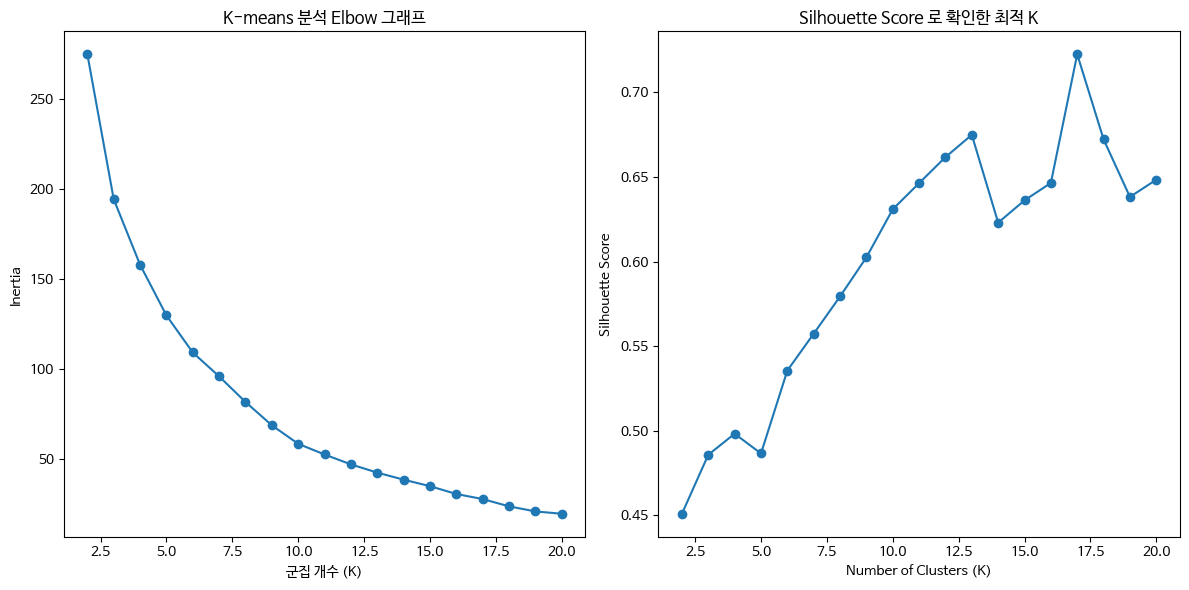

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_ch_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_ch_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 k로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=22)
kmeans.fit(df_ch_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_ch_tmp['cluster_num'] = kmeans.labels_

In [ ]:
silhouette_score(df_ch_tmp, kmeans.labels_)

0.785007544457302

In [ ]:
df_ch_tmp['상품명'] = df_tmp['상품명']
df_ch_tmp['은행명'] = df_tmp['금융회사']

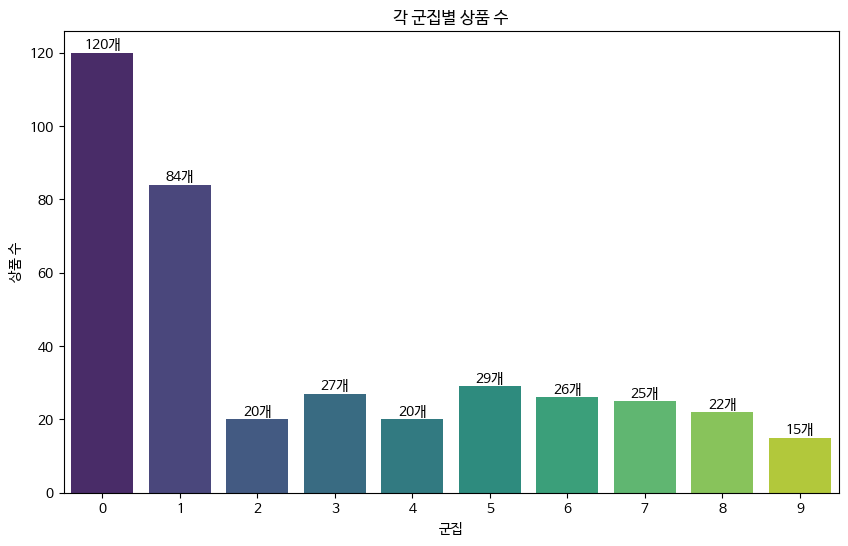

In [ ]:
df_result_km = df_ch_tmp.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

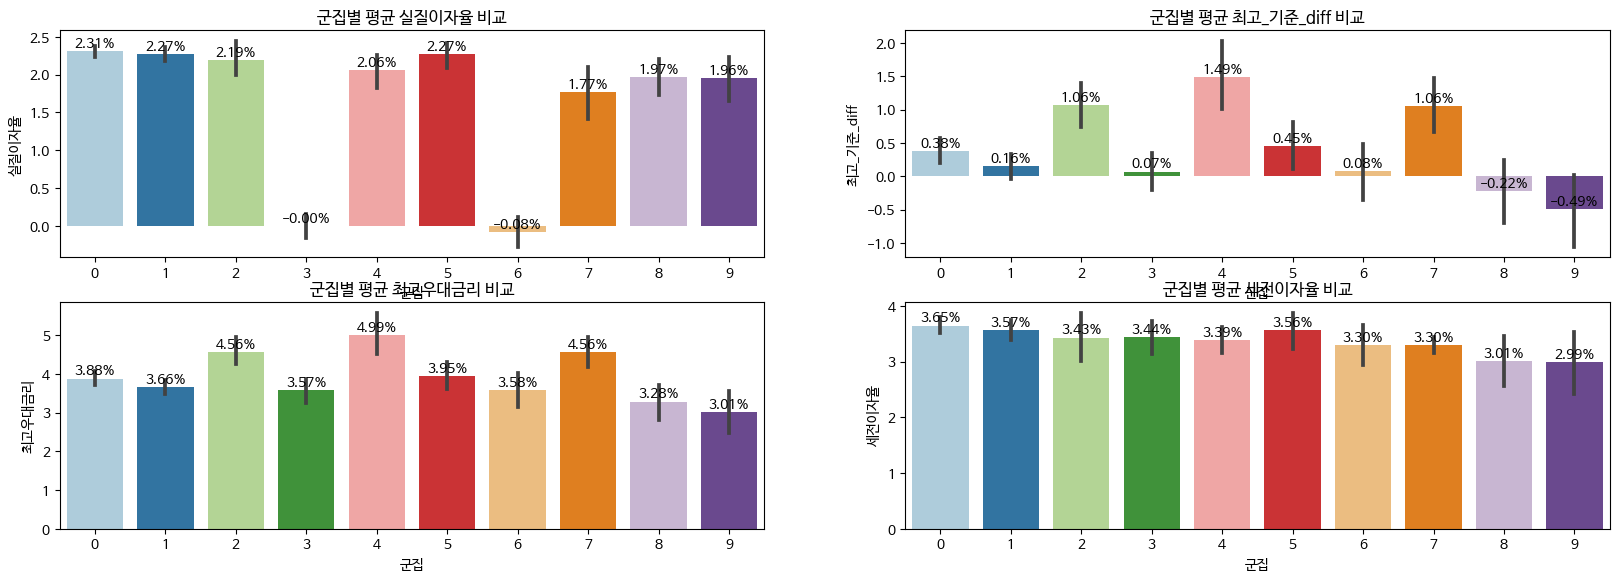

In [ ]:
df_ch_tmp[choice_num] = scaler.inverse_transform(df_ch_tmp[choice_num])

plt.figure(figsize=(20, 10))
for e, c in enumerate(choice_num):
    col_n = int((len(choice_num)) / 2 + 1)
    plot_cluster_comparison(df_ch_tmp,c,col_n, e+1)


plt.show()

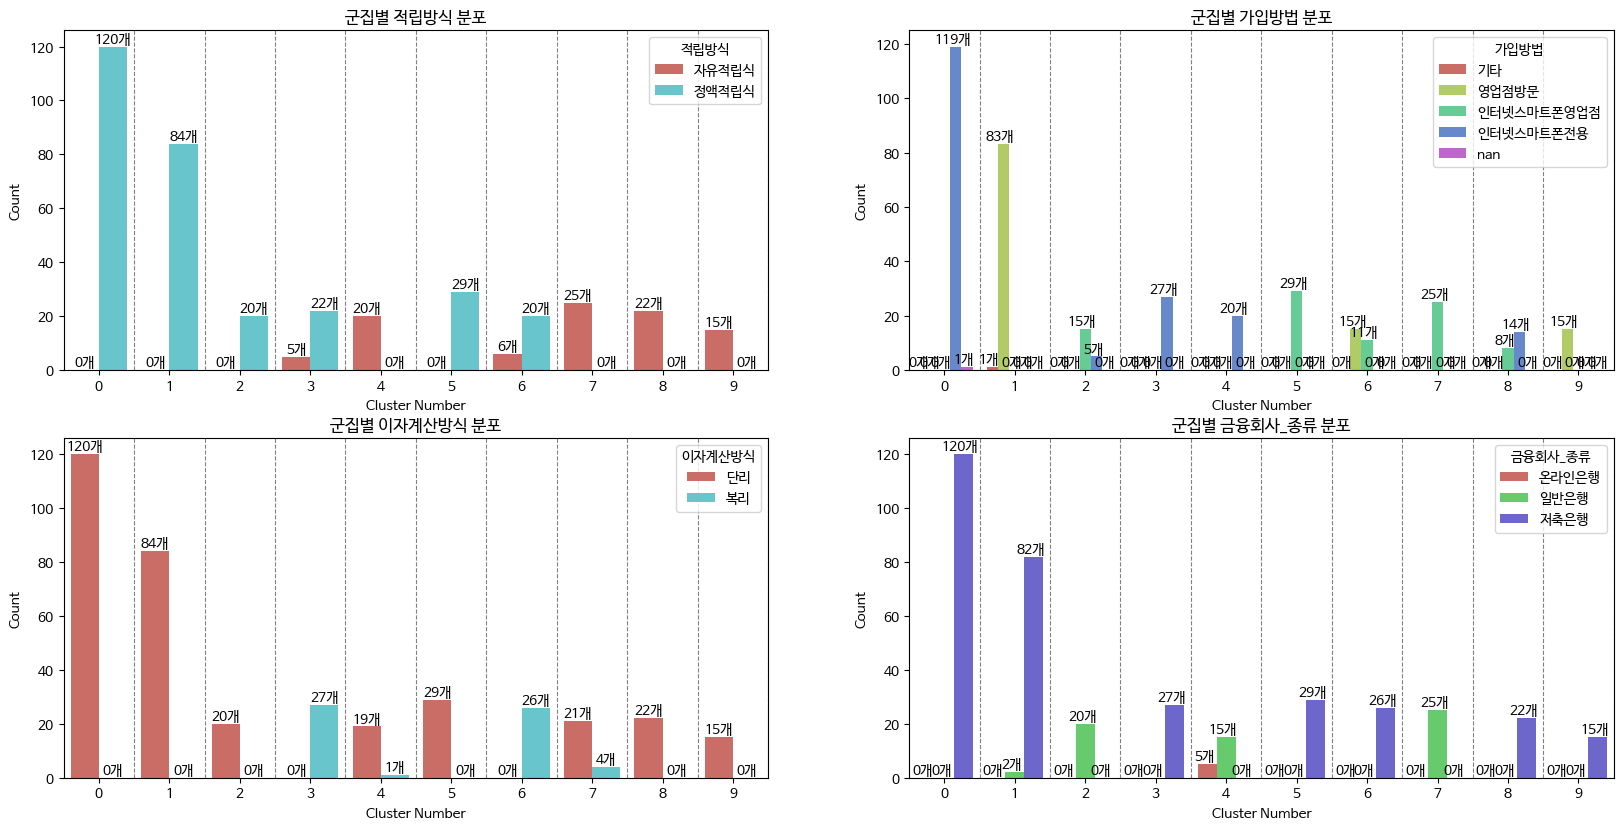

In [ ]:
plt.figure(figsize=(20, 15))
for e, c in enumerate(choice_cat):
    col_n = int((len(choice_cat)) / 2 + 1)
    plot_cluster_comparison_cat(df_ch_tmp,label_mapping, c,col_n, e+1)

plt.show()

In [ ]:
df_ch_tmp.to_csv("./is12_df.csv", encoding = 'cp949')

## [4-3] 24개월 상품 군집분석

### 통합 군집분석 : K-means

In [ ]:
df_tmp = is24_df.copy()

In [ ]:
# # 수치형 columns list
# num_col_list = ['세전이자율', '세후이자율', '최고우대금리','실질이자율', '최고_기본_diff','최고_기준_diff' ]

# # 범주형 columns list
# cat_col_list = ['적립방식','이자계산방식','가입방법','금융회사_종류', '등급', '나이제한', '가입방식우대_존재여부', '이체우대_존재여부',
#        '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부' ]

choice_num = [ '실질이자율','최고_기준_diff','최고우대금리','세전이자율']
choice_cat = ['적립방식','가입방법','이자계산방식','금융회사_종류']
choice_list = choice_num + choice_cat

In [ ]:
df_ch_tmp = df_tmp[choice_list]

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

df_ch_tmp[choice_num] = scaler.fit_transform(df_ch_tmp[choice_num])

In [ ]:

# 인코딩
label_mapping = {}

label_encoder = LabelEncoder()
for col in choice_cat:
    df_ch_tmp[col] = label_encoder.fit_transform(df_ch_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

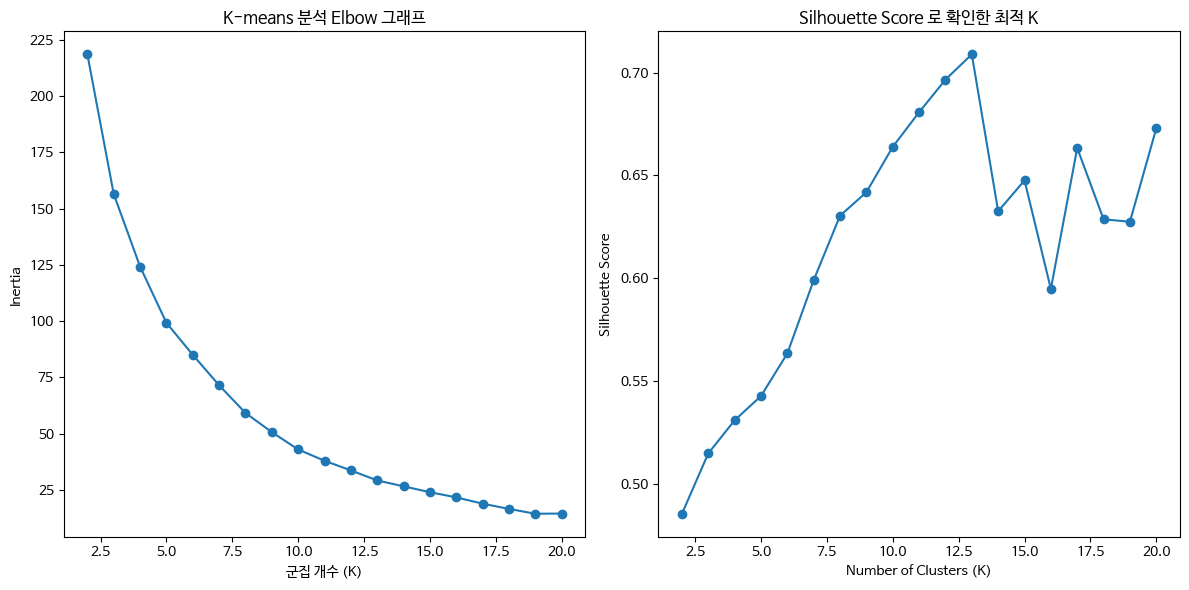

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_ch_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_ch_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 k로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=22)
kmeans.fit(df_ch_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_ch_tmp['cluster_num'] = kmeans.labels_

In [ ]:
df_ch_tmp['상품명'] = df_tmp['상품명']
df_ch_tmp['은행명'] = df_tmp['금융회사']

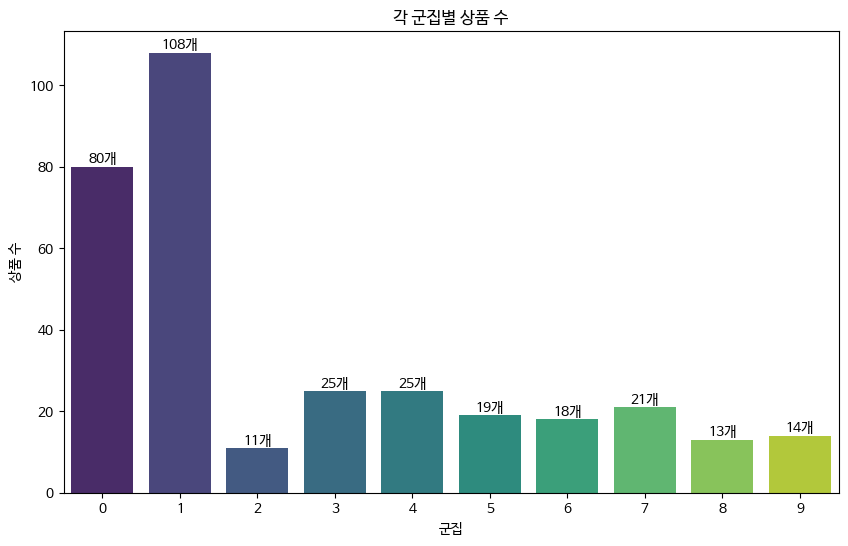

In [ ]:
df_result_km = df_ch_tmp.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

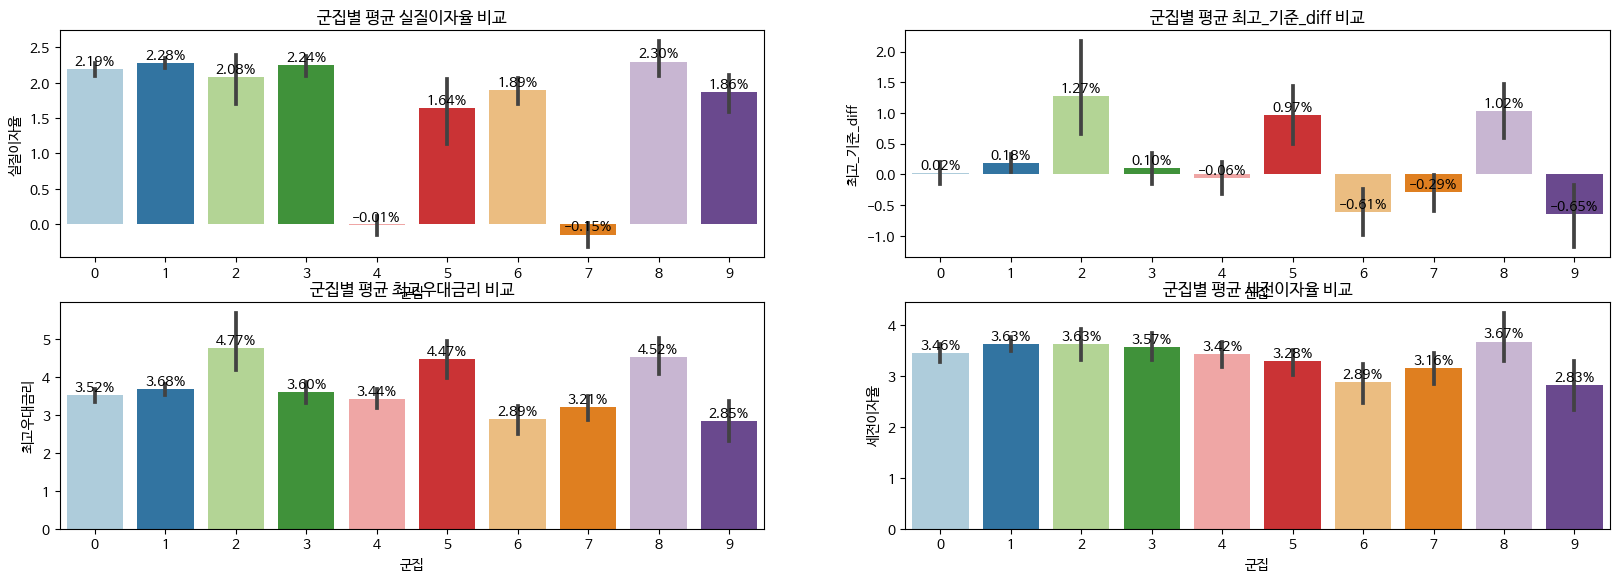

In [ ]:
df_ch_tmp[choice_num] = scaler.inverse_transform(df_ch_tmp[choice_num])

plt.figure(figsize=(20, 10))
for e, c in enumerate(choice_num):
    col_n = int((len(choice_num)) / 2 + 1)
    plot_cluster_comparison(df_ch_tmp,c,col_n, e+1)


plt.show()

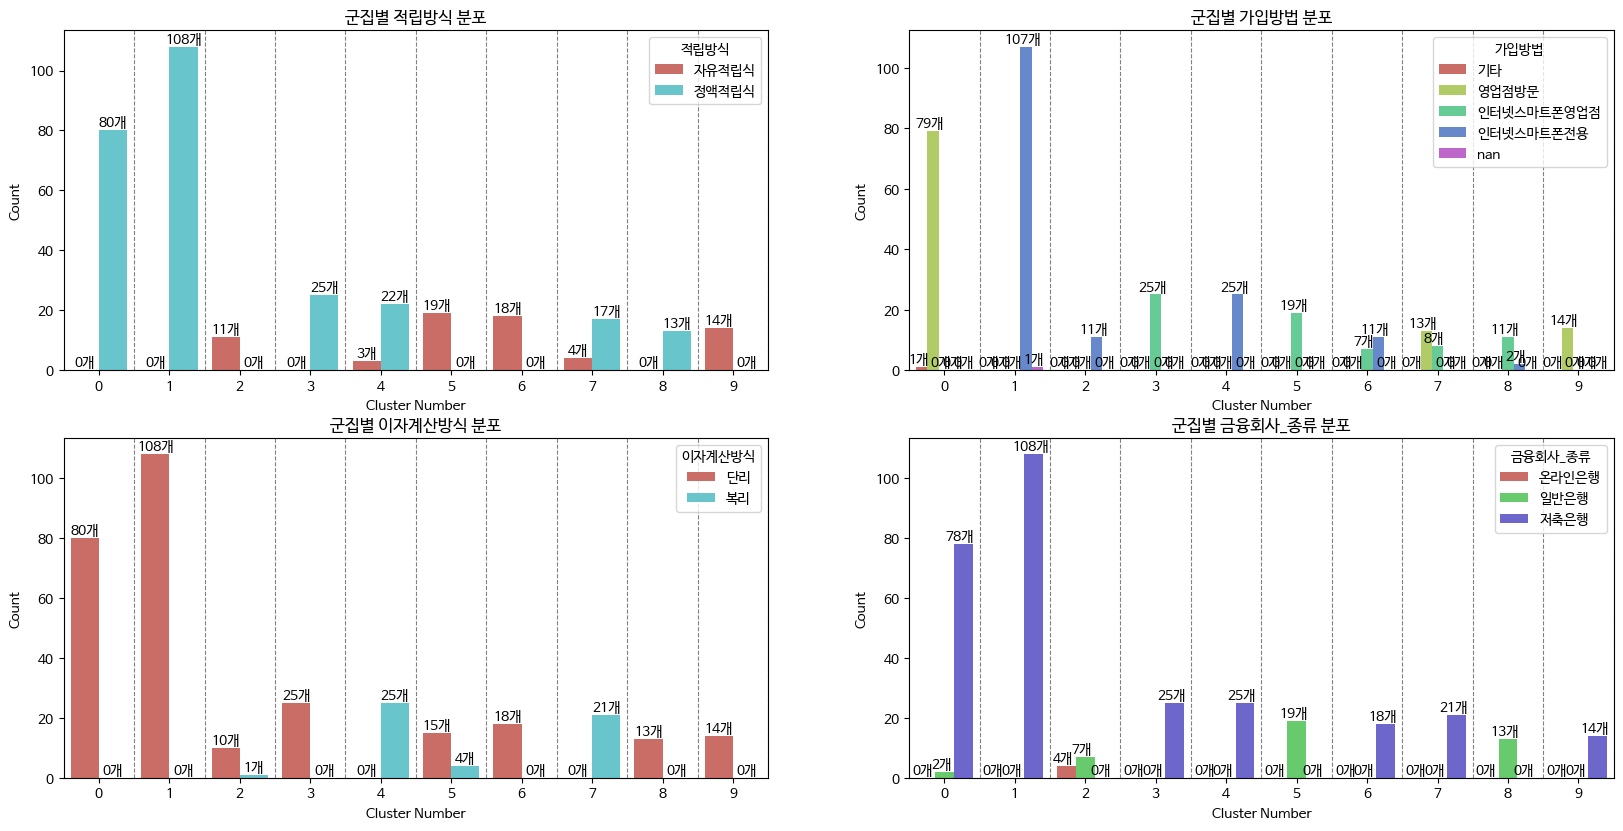

In [ ]:
plt.figure(figsize=(20, 15))
for e, c in enumerate(choice_cat):
    col_n = int((len(choice_cat)) / 2 + 1)
    plot_cluster_comparison_cat(df_ch_tmp,label_mapping, c,col_n, e+1)

plt.show()

In [ ]:
df_ch_tmp.to_csv("./is24_df.csv", encoding = 'cp949')

##[4-4] 36개월 상품 군집분석

### 통합 군집분석 : K-means

In [ ]:
df_tmp = is36_df.copy()

In [ ]:
# # 수치형 columns list
# num_col_list = ['세전이자율', '세후이자율', '최고우대금리','실질이자율', '최고_기본_diff','최고_기준_diff' ]

# # 범주형 columns list
# cat_col_list = ['적립방식','이자계산방식','가입방법','금융회사_종류', '등급', '나이제한', '가입방식우대_존재여부', '이체우대_존재여부',
#        '만기우대_존재여부', '실적우대_존재여부', '기타우대_존재여부' ]

choice_num = [ '실질이자율','최고_기준_diff','최고우대금리','세전이자율']
choice_cat = ['적립방식','가입방법','이자계산방식','금융회사_종류']
choice_list = choice_num + choice_cat

In [ ]:
df_ch_tmp = df_tmp[choice_list]

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

df_ch_tmp[choice_num] = scaler.fit_transform(df_ch_tmp[choice_num])

In [ ]:

# 인코딩
label_mapping = {}

label_encoder = LabelEncoder()
for col in choice_cat:
    df_ch_tmp[col] = label_encoder.fit_transform(df_ch_tmp[col])
    # 변환 전, 후의 매핑 정보 저장
    label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

- Elbow 그림으로 최적 군집 갯수 확인, 실루엣 score 확인

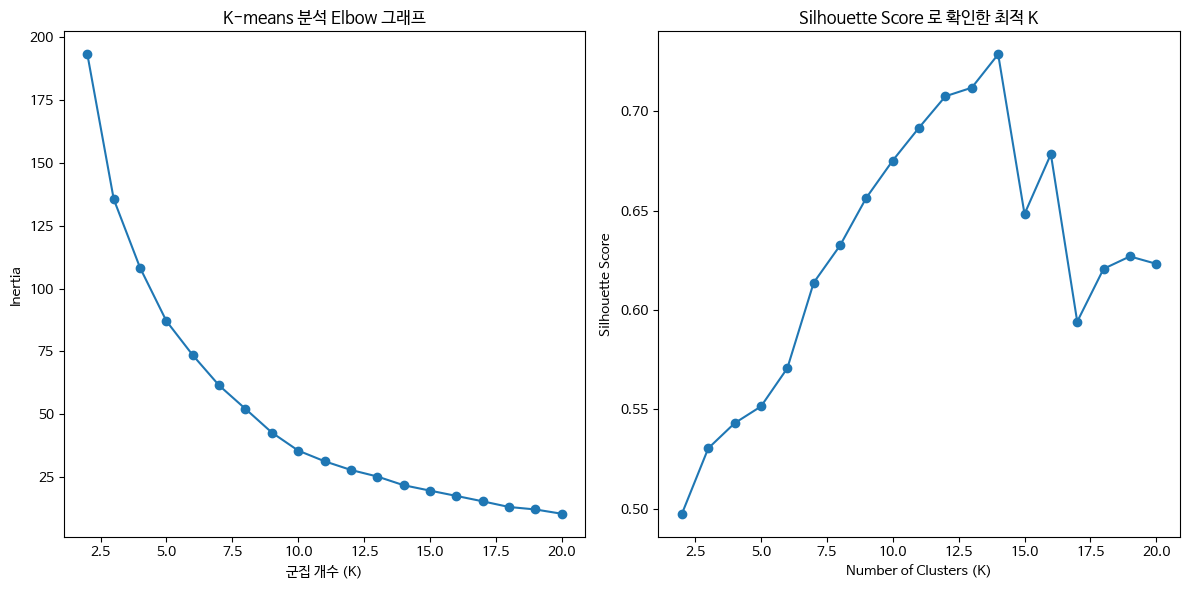

In [ ]:
# Elbow Method로 최적 K 찾기
inertia = []
silhouette = []
max_k = 20  # 최대 K 값 설정
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=22, max_iter = 777)
    kmeans.fit(df_ch_tmp)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_ch_tmp, kmeans.labels_))

# Inertia 그래프 그리기 [Inertia : 각 군집별로 중심점에 얼마나 가깝게 모여있는가?]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('K-means 분석 Elbow 그래프')
plt.xlabel('군집 개수 (K)')
plt.ylabel('Inertia')

# Silhouette 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette, marker='o')
plt.title('Silhouette Score 로 확인한 최적 K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

- 최적 k로 군집분석

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=22)
kmeans.fit(df_ch_tmp)

# 클러스터 결과를 데이터프레임에 추가
df_ch_tmp['cluster_num'] = kmeans.labels_

In [ ]:
df_ch_tmp['상품명'] = df_tmp['상품명']
df_ch_tmp['은행명'] = df_tmp['금융회사']

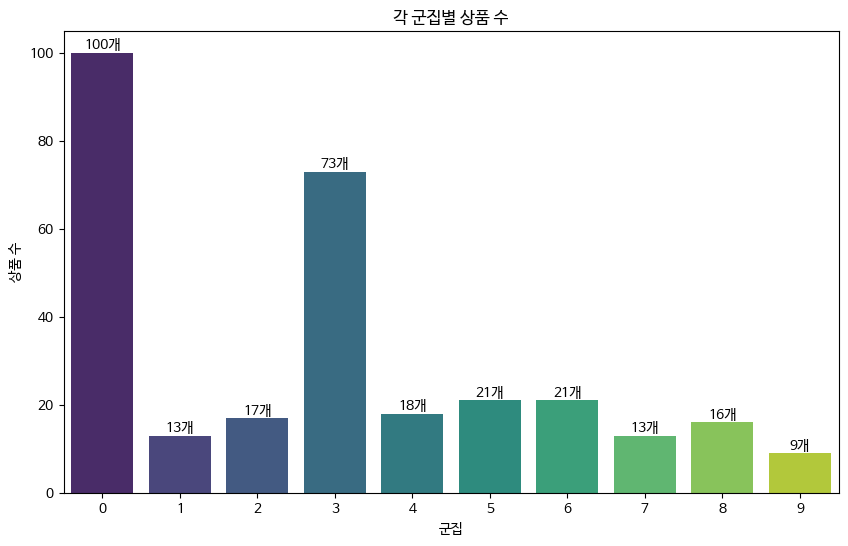

In [ ]:
df_result_km = df_ch_tmp.groupby(['cluster_num']).count()['상품명'].reset_index()

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='cluster_num', y='상품명', data= df_result_km, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}개', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('각 군집별 상품 수')
plt.xlabel('군집')
plt.ylabel('상품 수')
plt.show()

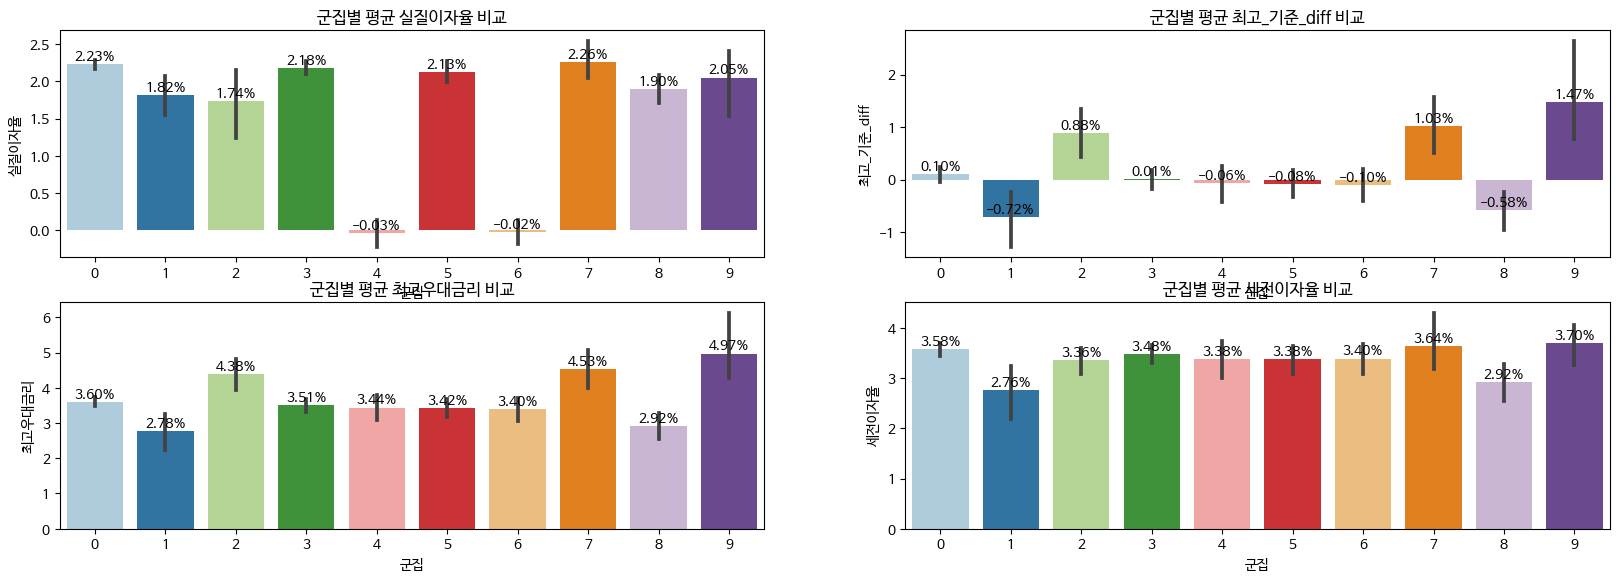

In [ ]:
df_ch_tmp[choice_num] = scaler.inverse_transform(df_ch_tmp[choice_num])

plt.figure(figsize=(20, 10))
for e, c in enumerate(choice_num):
    col_n = int((len(choice_num)) / 2 + 1)
    plot_cluster_comparison(df_ch_tmp,c,col_n, e+1)


plt.show()

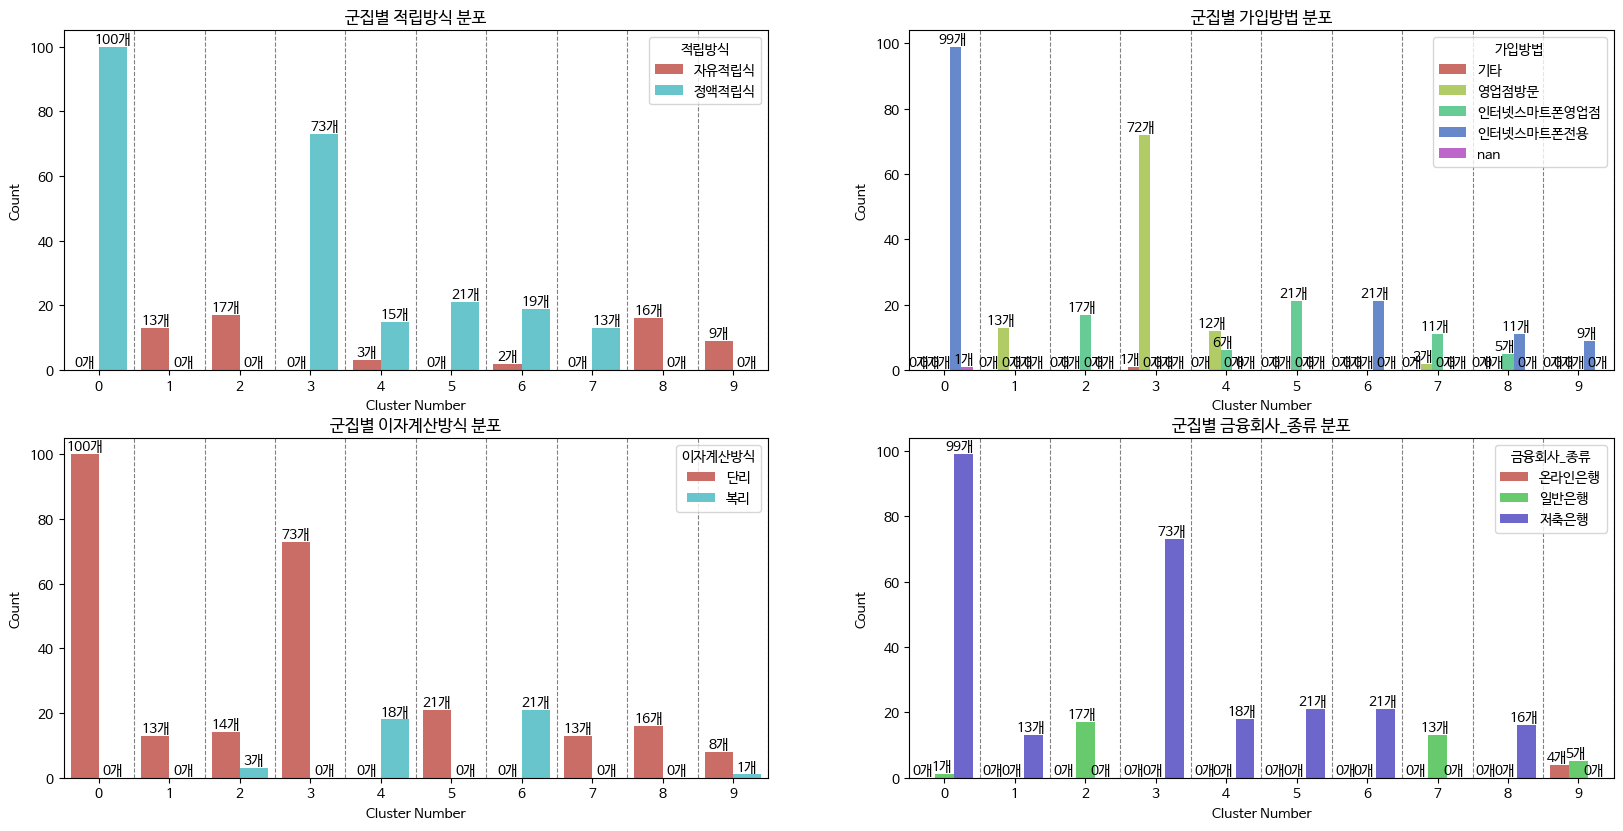

In [ ]:
plt.figure(figsize=(20, 15))
for e, c in enumerate(choice_cat):
    col_n = int((len(choice_cat)) / 2 + 1)
    plot_cluster_comparison_cat(df_ch_tmp,label_mapping, c,col_n, e+1)

plt.show()

In [ ]:
df_ch_tmp.to_csv("./is36_df.csv", encoding = 'cp949')